In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import time
import pickle

In [17]:
file_name = '011330p24_8'

In [18]:
df = pd.read_csv(f'C:\\big18\\final\with\\almost\\test_data\\{file_name}.csv', encoding='cp949')
df

,Unnamed: 0,날짜,시간,시가,고가,저가,종가,거래량,거래대금,누적체결매도수량,누적체결매수수량,code
0,378,20230814,901,2580,2610,2575,2610,120760,312320000,37863,82897,11330
1,377,20230814,902,2610,2690,2590,2670,148060,389990000,54757,214063,11330
2,376,20230814,903,2660,2700,2645,2665,216596,578260000,197810,287606,11330
3,375,20230814,904,2665,2670,2620,2665,99098,263080000,253764,330750,11330
4,374,20230814,905,2665,2680,2660,2680,47689,127290000,267181,365022,11330
...,...,...,...,...,...,...,...,...,...,...,...,...
374,4,20230814,1517,3255,3260,3245,3255,30030,97640000,6443748,7717691,11330
375,3,20230814,1518,3250,3260,3250,3255,29028,94450000,6460034,7730433,11330
376,2,20230814,1519,3255,3260,3240,3245,44417,144310000,6502793,7732091,11330
377,1,20230814,1520,3240,3250,3225,3240,70883,229610000,6556201,7749566,11330


In [19]:
# 매도수량
result = []
for i in range(len(df['누적체결매도수량'])):
    if i == 0:
        result.append(df['누적체결매도수량'][i])
    else:
        result.append(df['누적체결매도수량'][i] - df['누적체결매도수량'][i - 1])
df['매도량'] = result

# 매수수량
result = []
for i in range(len(df['누적체결매수수량'])):
    if i == 0:
        result.append(df['누적체결매수수량'][i])
    else:
        result.append(df['누적체결매수수량'][i] - df['누적체결매수수량'][i - 1])
df['매수량'] = result

In [20]:
# 분리된 날짜 시간 붙이기모링
df['Unnamed: 0'] = pd.to_datetime(df['날짜'].astype(str) + df['시간'].astype(str).str.zfill(4), format='%Y%m%d%H%M')
df.to_csv(f'./{file_name}.csv', index=False)

In [21]:
data = pd.read_csv(f'./{file_name}.csv')
data = data[['Unnamed: 0', '종가', '매도량', '매수량']]
data['power'] = data['매수량'] - data['매도량']
data = data.rename(columns={'종가':'open', 'Unnamed: 0':'Time'})
data = data.drop(['매도량', '매수량'], axis=1)
data.to_csv(f'{file_name}RL.csv', index=False)

In [10]:
##      데이터 전처리 함수
def data_preprocess(directory):
    divisor = 728002365
    df = pd.read_csv(directory)
    # df = df[['Time','open','volume']]
    df['Time'] = pd.to_datetime(df['Time'])  # datetime 형식으로 변환
    df.set_index('Time', inplace=True)

    # df['openChange'] = (df['open'] - df['open'].shift(1)) / df['open'].shift(1) * 100
    df['openChange'] = df['open'] / df['open'].shift(1) 
    df['openChange'] = df['openChange'].round(3)
    df['openChange'].fillna(0, inplace=True)

    df['powerRound'] = (df['power'] * 100000 / divisor)
    df['powerRound'] = df['powerRound'].round(1)
    # df['powerRound'] = ((df['power'] - df['power'].shift(1)) / abs(df['power'].shift(1))).round(1)
    df['powerRound'].fillna(0, inplace=True)
    
    print(df)
    print(len(df))

    return df

In [30]:
action_list = []

actions_dictionary = {
    0: "매수",
    1: "홀딩",
    2: "매도"
}

def action_choose(bank_account, stock_account, open_price):
  if bank_account >= open_price:
    if stock_account > 0 :
      action_list = [0,1,2]
    else:
      action_list = [0,1]

  else :
    if stock_account > 0 :
      action_list = [1,2]
    else:
      action_list = [1]

  return action_list

def stock_action(action, bank_account, stock_account, stock_account_number, open_price, account_sum):
  if action == 0:                                           # 매수
    number_stock = bank_account // open_price / 2                                        # 매수할 주식 수
    amount_stock = number_stock * open_price                # 총 매수 금액
    charge_fee = 0.00015                                        # 수수료
    bank_account = bank_account - amount_stock * (1 + charge_fee) # 예수금 잔액
    stock_account_number += number_stock                    # 보유 주식 수
    stock_account = open_price * stock_account_number       # 주식 잔고 잔액
    
  elif action == 1:                                         # 홀딩
    # bank_account = bank_account
    # stock_account = stock_account_number * open_price
    pass
  
  elif action == 2:                                         # 매도
    number_stock = stock_account_number / 2
    amount_stock = number_stock * open_price                           # 매도할 주식 금액
    charge_fee = 0.00195                                        # 수수료
    bank_account = bank_account + amount_stock * (1 - charge_fee) # 예수금 잔액
    stock_account_number -= number_stock                           # 보유 주식 수
    stock_account = stock_account_number * open_price       # 주식 잔고 잔액
  
  account_sum = bank_account + stock_account
  return bank_account, stock_account, stock_account_number, account_sum

def states_maker(df, observeColumn, minute):
  open_change = df[observeColumn]
  states = []
  num_rows = len(open_change)
  volume_round = df['powerRound']

  for i in range(num_rows):
    if i < minute - 1:
      state = (0,) * (minute - 1 - i) + tuple(open_change[:i + 1]) + (0,) * (minute - 1 - i) + tuple(volume_round[:i + 1])
      states.append(state)
    else:
      state = tuple(open_change[i - minute + 1:i + 1]) + tuple(volume_round[i - minute + 1:i + 1],)
      # state = state + tuple(volume_round[i - minute + 1:i],)
      states.append(state)

  df['state'] = states
  print(df)
  
  return states

def reset_bank_account(initial_bank_account):
  bank_account = initial_bank_account
  initial_bank_account = initial_bank_account
  stock_account = 0
  stock_account_number = 0
  account_sum = 0
  save_money = 0

  return bank_account, initial_bank_account, stock_account, stock_account_number, account_sum, save_money

def sort_key(state_to_index):
    return (state_to_index[5], 
            state_to_index[2], 
            state_to_index[4], 
            state_to_index[1], 
            state_to_index[3], 
            state_to_index[0])

def find_insert_index(sorted_states, new_state):
    new_state_key = sort_key(new_state)
    for index, state in enumerate(sorted_states):
        if sort_key(state) < new_state_key:
            return index
    return len(sorted_states)

In [12]:
class ReplayBuffer:
  def __init__(self, capacity):
    self.capacity = capacity
    self.buffer = deque(maxlen=capacity)

  def add(self, experience):
    self.buffer.append(experience)

  def sample_recent(self, num_samples):
    return list(self.buffer)[-num_samples:] if len(self.buffer) >= num_samples else list(self.buffer)

In [13]:
def Dueling_Q_Update(current_state_index, action, reward, next_state_index, alpha, gamma, Q, V, A):
  next_q_values = Q[next_state_index]
  target = reward + gamma * np.max(next_q_values)
  
  V[current_state_index] = np.mean(Q[current_state_index])
  A[current_state_index, action] = target - V[current_state_index]
  Q[current_state_index, action] += alpha * (V[current_state_index] + A[current_state_index, action] - Q[current_state_index, action])

In [24]:
alpha = 1.0               # 학습률 : 0 ~ 1 = 보수 ~ 진보
gamma = 0.9               # 할인률 : 0 ~ 1 = 단타 ~ 장타
epsilon = 0.8
episodes = 1000
# batch_size = 16
temp_reward_avg = 0
best_reward_episode = 0
buffer_capacity = 10

initial_bank_account= 40000000
valid_initial_bank_account = 90000000
minute = 3
observe_column = 'openChange'
average_minute = 60

file_path = 'C:\\big18\\final\with\\rl\\000660RL.csv'   #'D:/StockQ-Learning/bitcoin_data(2020-12-05).csv'
valid_file_path = f'C:\\big18\\final\with\\rl\\{file_name}RL.csv'

Q_directory = 'q_table3.npy'

In [25]:
# df = data_preprocess(file_path)
df = data_preprocess(valid_file_path)

index_list = df.index.tolist()
open_price = df['open'].tolist()

rewards = []
avg_rewards = []
states = states_maker(df, observe_column, minute)

unique_states = list(set(states))
num_states = len(unique_states)
state_to_index = {state: idx for idx, state in enumerate(unique_states)}
state_to_index = sorted(state_to_index.keys(), key=sort_key, reverse=True)
state_to_index = {state: index for index, state in enumerate(state_to_index)}

print(f'데이터프레임 길이 : {len(df)}, 인덱스 길이 : {len(state_to_index)}')

Q = np.random.rand(len(unique_states), 3) * 0.01
V = np.random.rand(len(unique_states)) * 0.01
A = np.random.rand(len(unique_states), 3) * 0.01

print(state_to_index)

with open('states_to_index.pkl', 'wb') as f:
    pickle.dump(state_to_index, f)

                     open   power  openChange  powerRound
Time                                                     
2023-08-14 09:01:00  2610   45034       0.000         6.2
2023-08-14 09:02:00  2670  114272       1.023        15.7
2023-08-14 09:03:00  2665  -69510       0.998        -9.5
2023-08-14 09:04:00  2665  -12810       1.000        -1.8
2023-08-14 09:05:00  2680   20855       1.006         2.9
...                   ...     ...         ...         ...
2023-08-14 15:17:00  3255  -11616       0.998        -1.6
2023-08-14 15:18:00  3255   -3544       1.000        -0.5
2023-08-14 15:19:00  3245  -41101       0.997        -5.6
2023-08-14 15:20:00  3240  -35933       0.998        -4.9
2023-08-14 15:30:00  3220  253038       0.994        34.8

[379 rows x 4 columns]
379
                     open   power  openChange  powerRound  \
Time                                                        
2023-08-14 09:01:00  2610   45034       0.000         6.2   
2023-08-14 09:02:00  2670  114272  

C:\Users\G013\AppData\Local\Temp\ipykernel_8736\2731573416.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['openChange'].fillna(0, inplace=True)
C:\Users\G013\AppData\Local\Temp\ipykernel_8736\2731573416.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

In [21]:
df['openChange'].value_counts()

openChange
1.000    76968
0.999    41906
1.001    40435
1.002    10948
0.998    10834
         ...  
0.980        1
0.962        1
0.971        1
0.968        1
1.048        1
Name: count, Length: 83, dtype: int64

Q-Learning

In [22]:
for episode in range(episodes):
  if episode % 10 == 0:
    start_time = time.time()
  state = states[0]
  replay_buffer = ReplayBuffer(buffer_capacity)
  reward = 0
  bank_account, initial_bank_account, stock_account, stock_account_number, account_sum, save_money = reset_bank_account(initial_bank_account)
  
  for i in range(0, len(index_list)):
    current_state_index = state_to_index[state]
    
    if random.uniform(0, 1) < epsilon:
      action_list = action_choose(bank_account, stock_account, open_price[i])
      action = random.choice(action_list)
    else:
      # action = np.argmax(Q[current_state_index])
      valid_actions = action_choose(bank_account, stock_account, open_price[i])
      action_values = [Q[current_state_index, a] for a in valid_actions]
      max_action_index = np.argmax(action_values)
      # print(max_action_index)
      action = valid_actions[max_action_index]
    
    if i < len(states) - 1:
      next_state = states[i+1]
    else:
      break

    bank_account, stock_account, stock_account_number, account_sum = stock_action(action, bank_account, stock_account, stock_account_number, open_price[i], account_sum)
    
    # if bank_account > open_price[i] + 10000000:
    #   save_money += bank_account - open_price[i] - 10000000
    #   bank_account -= bank_account - open_price[i] - 10000000
    
    # account_sum += save_money
    
    rate = (account_sum - initial_bank_account) / initial_bank_account * 100
    reward = rate
    # print(f'회차 : {i}, 액션:{actions_dictionary[action]}, 저축 : {save_money}, 시가:{open_price[i]},예수금:{bank_account}, 주식잔고:{stock_account}, 보유주식수:{stock_account_number}, 계좌총액:{account_sum}, 수익률:{rate}')
    next_state_index = state_to_index[next_state]
    
    experience = (current_state_index, action, reward, next_state_index)
    replay_buffer.add(experience)
    
    # Q[current_state_index, action] += alpha * (reward + gamma * np.max(Q[next_state_index]) - Q[current_state_index, action])
    
    Dueling_Q_Update(current_state_index, action, reward, next_state_index, alpha, gamma, Q, V, A)
    
    if len(replay_buffer.buffer) >= 10:
      recent_experiences = replay_buffer.sample_recent(10)
      for experience in recent_experiences:
        current_state_index, action, reward, next_state_index = experience
        Dueling_Q_Update(current_state_index, action, reward, next_state_index, alpha, gamma, Q, V, A)
    
    state = next_state

  alpha = max(0.01, (episodes - episode) / episodes)
  epsilon = epsilon * 0.9
  
  rewards.append(reward)
  avg_reward = np.mean(rewards[-average_minute:])
  avg_rewards.append(avg_reward)
  
  if avg_reward >= temp_reward_avg:
    BEST_Q = Q
    print(f'최고 수익률 업데이트 : {temp_reward_avg:.2f}%  ->  {avg_reward:.2f}%')
    temp_reward_avg = avg_reward
    best_reward_episode = episode

  print(f'episode : {episode}, reward : {reward:.2f}, epsilon : {epsilon}, alpha : {alpha}')
  print(f'최종 금액 : {account_sum}')
  if episode % 10 == 0:
    end_time = time.time()
    execution_time = (end_time - start_time) * (episodes-episode)
    minutes = int(execution_time // 60)
    seconds = execution_time % 60
    time_to_end = f"** 예상 남은 시간: {minutes}분 {seconds:.3f}초 **"
    time_length = len(time_to_end) + 8
    print("*" * time_length)
    print(time_to_end)
    print("*" * time_length)
  # input()
np.save(Q_directory, BEST_Q)
print(f'최종 저장된 에피소드 : {best_reward_episode}, 수익율 : {temp_reward_avg}')

episode : 0, reward : -7.70, epsilon : 0.7200000000000001, alpha : 1.0
최종 금액 : 36918180.33000079
************************************
** 예상 남은 시간: 519분 11.695초 **
************************************
최고 수익률 업데이트 : 0.00%  ->  2.59%
episode : 1, reward : 12.89, epsilon : 0.6480000000000001, alpha : 0.999
최종 금액 : 45156282.480000615
episode : 2, reward : -16.10, epsilon : 0.5832000000000002, alpha : 0.998
최종 금액 : 33560587.91999806
episode : 3, reward : 15.22, epsilon : 0.5248800000000001, alpha : 0.997
최종 금액 : 46088310.86500049
episode : 4, reward : -9.05, epsilon : 0.47239200000000015, alpha : 0.996
최종 금액 : 36379404.655000605
episode : 5, reward : 2.55, epsilon : 0.42515280000000016, alpha : 0.995
최종 금액 : 41021158.0749995
episode : 6, reward : 7.93, epsilon : 0.3826375200000002, alpha : 0.994
최종 금액 : 43171188.97499903
episode : 7, reward : -1.69, epsilon : 0.3443737680000002, alpha : 0.993
최종 금액 : 39325913.92500056
episode : 8, reward : -11.10, epsilon : 0.30993639120000016, alpha : 0.992

Rewards 시각화

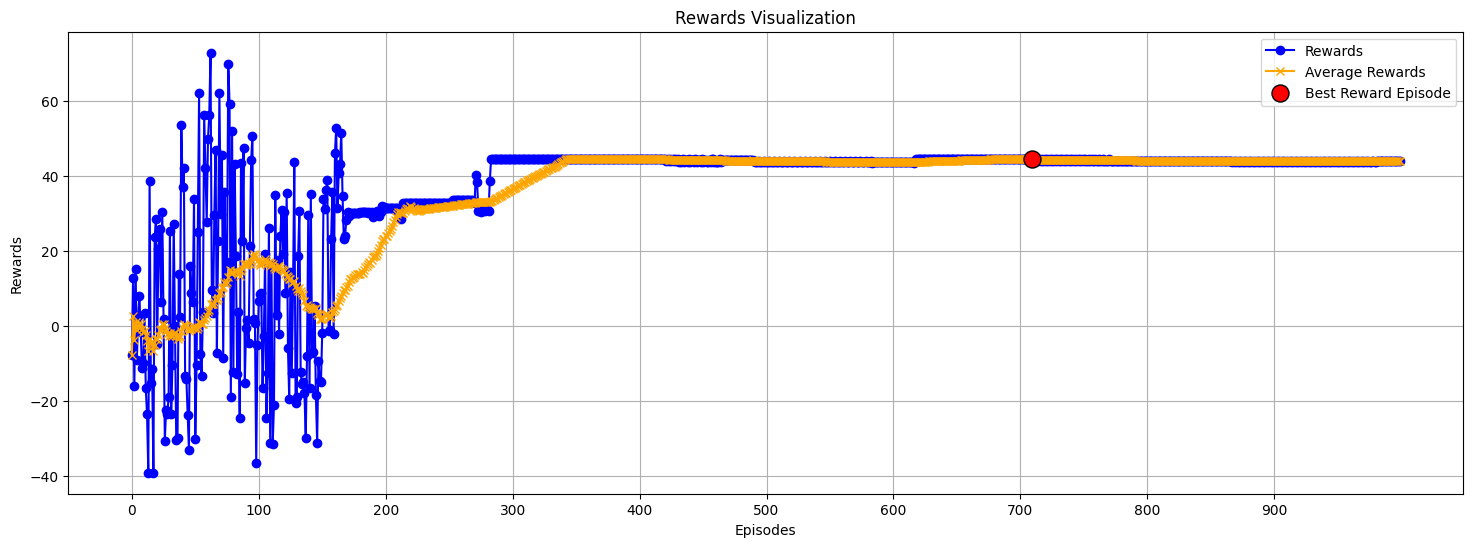

In [23]:
x = range(len(rewards))

plt.figure(figsize=(18, 6))
plt.plot(x, rewards, marker='o', label='Rewards', color='blue')
plt.plot(x, avg_rewards, marker='x', label='Average Rewards', color='orange')

plt.xticks(ticks=range(0, len(rewards), len(rewards) // 10))

best_avg_reward = avg_rewards[best_reward_episode]
plt.scatter(best_reward_episode, best_avg_reward, color='red', s=150, label='Best Reward Episode', edgecolor='black', zorder=5)

plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Rewards Visualization')

plt.legend()
plt.grid()
plt.show()

모의 투자

In [31]:
Q_table = np.load(Q_directory)

def trading_simulation(valid_file_path, Q_table, state_to_index, valid_initial_bank_account):
  valid_df = data_preprocess(valid_file_path)
  valid_states = states_maker(valid_df, observe_column, minute)

  bank_account, initial_bank_account, stock_account, stock_account_number, account_sum, save_money = reset_bank_account(valid_initial_bank_account)
  action_list = []

  buy_sum, hold_sum, sell_sum = 0, 0, 0

  for index, row in valid_df.iterrows():
    open_price = row['open']
    current_state = row['state']
    try:
      current_state_index = state_to_index[current_state]
    except KeyError:
      current_state_index  = find_insert_index(state_to_index, current_state)
      if current_state_index >= len(state_to_index):
        current_state_index -= 1 
    q_value = Q_table[current_state_index]
    q_value_sorted = np.argsort(q_value)[::-1]
    action_list = action_choose(bank_account, stock_account, open_price)
    
    if q_value_sorted[0] in action_list:
      action = q_value_sorted[0]
    elif q_value_sorted[0] not in action_list:
      if q_value_sorted[1] in action_list:
        action = q_value_sorted[1]
      elif q_value_sorted[1] not in action_list:
        action = q_value_sorted[2]
    
    
    bank_account, stock_account, stock_account_number, account_sum = stock_action(action, bank_account, stock_account, stock_account_number, open_price, account_sum)
    rate = (account_sum - initial_bank_account) / initial_bank_account * 100

    if action == 0:
      buy_sum += 1
    elif action == 1:
      hold_sum += 1
    else:
      sell_sum += 1
    
    print(f'시간:{index}, 액션:{actions_dictionary[action]}, 시가:{open_price},예수금:{bank_account}, 주식잔고:{stock_account}, 보유주식수:{stock_account_number}, 계좌총액:{account_sum}, 수익률:{rate}')

  rate_buy = round((buy_sum / len(valid_df)*100),2)
  rate_hold = round((hold_sum / len(valid_df)*100),2)
  rate_sell = round((sell_sum / len(valid_df)*100),2)

  print(f'매수 비율 : {rate_buy}%, 홀드 비율 : {rate_hold}%, 매도 비율 : {rate_sell}%,')

trading_simulation(valid_file_path, Q_table, state_to_index, valid_initial_bank_account)

                     open   power  openChange  powerRound
Time                                                     
2023-08-14 09:01:00  2610   45034       0.000         6.2
2023-08-14 09:02:00  2670  114272       1.023        15.7
2023-08-14 09:03:00  2665  -69510       0.998        -9.5
2023-08-14 09:04:00  2665  -12810       1.000        -1.8
2023-08-14 09:05:00  2680   20855       1.006         2.9
...                   ...     ...         ...         ...
2023-08-14 15:17:00  3255  -11616       0.998        -1.6
2023-08-14 15:18:00  3255   -3544       1.000        -0.5
2023-08-14 15:19:00  3245  -41101       0.997        -5.6
2023-08-14 15:20:00  3240  -35933       0.998        -4.9
2023-08-14 15:30:00  3220  253038       0.994        34.8

[379 rows x 4 columns]
379
                     open   power  openChange  powerRound  \
Time                                                        
2023-08-14 09:01:00  2610   45034       0.000         6.2   
2023-08-14 09:02:00  2670  114272  

C:\Users\G013\AppData\Local\Temp\ipykernel_8736\2731573416.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['openChange'].fillna(0, inplace=True)
C:\Users\G013\AppData\Local\Temp\ipykernel_8736\2731573416.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when